## Eigenportfolios from S&P500 Stock Data Using Principal Component Analysis (PCA)

In this notebook, I construct eigenporfolios using price data from stocks included in the S&P500 and evaluate their performance as measured by Sharpe ratio. 

In [42]:
import os
import os.path
import numpy as np
import datetime
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [43]:
# load dataset
asset_prices = pd.read_csv(os.getcwd() + '/data/spx_holdings_and_spx_closeprice.csv', 
                           date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                           index_col = 0).dropna()
n_stocks_show = 12
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250


In [44]:
asset_prices.iloc[:, :n_stocks_show].tail()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2013-12-16,39.5014,21.4325,79.6429,68.45,36.53,58.50,48.74,40.66,68.0013,47.185,35.25,45.97
2013-12-17,40.3094,21.7237,79.2843,68.35,36.61,57.67,48.94,41.48,67.7689,47.500,35.25,45.82
2013-12-18,41.3964,22.0148,78.6814,69.61,38.12,59.04,49.78,43.14,69.3830,48.270,35.90,46.51
2013-12-19,41.0317,22.3284,77.7800,69.63,38.03,58.13,49.66,43.79,69.6769,48.045,35.79,46.38
2013-12-20,40.7313,22.2612,78.4314,69.82,37.84,59.26,50.01,43.36,70.1550,49.190,36.15,46.72


In [45]:
print('Last column contains SPX index prices:')
asset_prices.iloc[:, -10:].head()

Last column contains SPX index prices:


,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


#### Part 1 (Asset Returns Calculation)

Calculate percent returns, also known as simple returns using asset_prices. assign the result to variable asset_returns. Keep only not-nan values in the resulting pandas.DataFrame

Calculate de-meaned returns and scale them by standard deviation $\sigma$. Assign result to normed_returns variable

Compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation. This normalization is required by PCA.

In [46]:
asset_returns = asset_prices.pct_change().dropna()
normed_returns = (asset_returns - asset_returns.mean())/asset_returns.std()
normed_returns.iloc[-10:, -10:]

,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2013-12-09,-0.573580,-0.282141,-0.495532,-0.551918,0.026234,-0.514798,0.033484,0.538695,0.290314,0.125778
2013-12-10,0.207785,-0.559295,0.728808,-1.125005,-0.153858,0.462602,-0.163188,0.271541,-0.018553,-0.253900
2013-12-11,-1.093059,-0.009310,0.294757,-1.039605,-0.319014,0.659458,-1.220152,-0.915225,-0.564173,-0.872207
2013-12-12,-0.162619,0.549531,0.336280,0.067172,-0.805115,-0.107159,-0.270004,0.254809,-0.018337,-0.298802
2013-12-13,-0.060486,0.540675,-0.256343,0.158149,0.044845,0.392133,-0.071433,0.885423,0.504771,-0.019997
2013-12-16,0.852722,0.965219,-1.168885,0.884751,0.095865,0.656639,0.180014,-0.238498,0.465047,0.467931
2013-12-17,0.275173,0.517307,-0.086106,-0.306213,0.589689,-0.118610,-0.549523,0.025268,-0.260013,-0.247921
2013-12-18,0.864485,0.509435,0.600714,1.210605,-0.190024,0.925461,0.756998,0.058428,0.952458,1.252703
2013-12-19,0.210069,0.399574,-0.100159,-0.757419,-0.208023,0.304913,-0.772205,1.544228,-0.167775,-0.056358
2013-12-20,0.827306,0.748420,0.372443,1.048113,0.264046,0.436874,0.320641,-0.740854,0.373717,0.353859


In [47]:
train_end = datetime.datetime(2012, 3, 26) 

df_train = normed_returns[normed_returns.index <= train_end].copy()
df_test = normed_returns[normed_returns.index > train_end].copy()

df_raw_train = asset_returns[asset_returns.index <= train_end].copy()
df_raw_test = asset_returns[asset_returns.index > train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3055, 419)
Test dataset: (437, 419)


#### Part 2 (PCA fitting)

Now compute PCA using all available data. Once we have PCA computed, fix the variance explained at some number and see what is the smallest number of components needed to explain this variance.

**Instructions:**
- Calculate covariance matrix using training data set, i.e. **df_train** for all assets.  Assign results to **cov_matrix**.
- Calculate covariance matrix using training data set, i.e. **df_raw_train** for all assets.  Assign results to **cov_matrix_raw**.
- Use scikit-learn PCA to fit PCA model to **cov_matrix**. Assign fitted model to **pca**

In [48]:
import sklearn.decomposition
import seaborn as sns

stock_tickers = normed_returns.columns.values[:-1]

n_tickers = len(stock_tickers)

if df_train is not None and df_raw_train is not None:
    stock_tickers = asset_returns.columns.values[:-1]
    
    cov_matrix = df_train.iloc[:,:-1].cov()
    pca = sklearn.decomposition.PCA().fit(cov_matrix)
      
    # cumulative variance explained
    var_threshold = 0.8
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
    print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

4 components explain 80.00% of variance


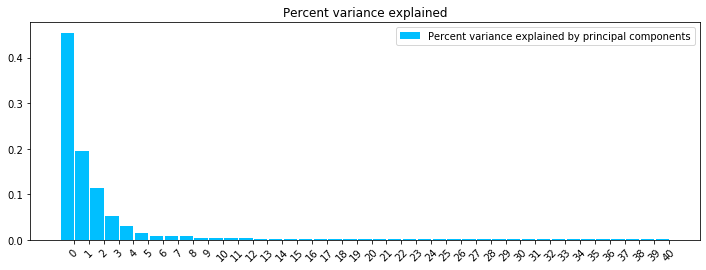

In [49]:
bar_width = .9
n_asset = int((1 / 10) * normed_returns.shape[1])
x_indx = np.arange(n_asset)
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
# Eigenvalues are measured as percentage of explained variance.
rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
ax.set_xticks(x_indx + bar_width / 2)
ax.set_xticklabels(list(range(n_asset)), rotation=45)
ax.set_title('Percent variance explained')
ax.legend((rects[0],), ('Percent variance explained by principal components',))

#### Part 3 (Eigenportfolio construction)

Now look at the first two eigen portfolios. Sort each of the first two eigenportfolios by weight and plot the weights.

Sum of weights of first eigen-portfolio: 100.00


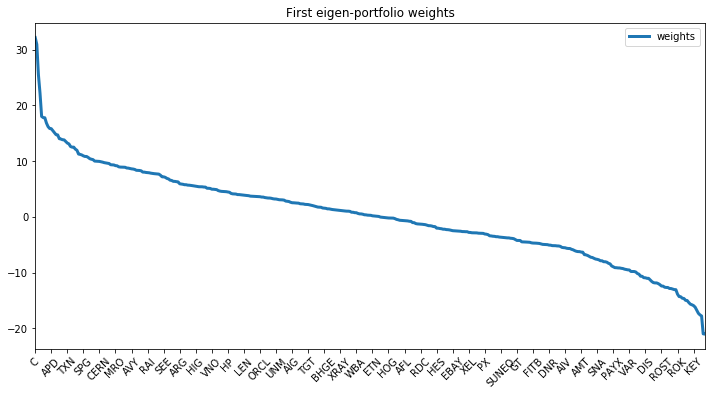

In [58]:
pcs = pca.components_
pc_w = pcs[:, 0] / sum(pcs[:, 0])
eigen_prtf1 = pd.DataFrame(data ={'weights': 100*pc_w.squeeze()}, index = stock_tickers)
eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
eigen_prtf1.plot(title='First eigen-portfolio weights', 
                 figsize=(12,6), 
                 xticks=range(0, len(stock_tickers),10), 
                 rot=45, 
                 linewidth=3)

Sum of weights of second eigen-portfolio: 100.00


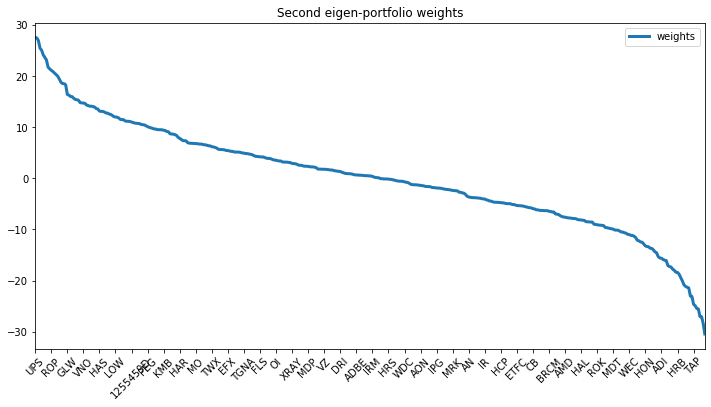

In [59]:
pcs = pca.components_
pc_w = pcs[:, 1] / sum(pcs[:, 1])
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
eigen_prtf2.plot(title='Second eigen-portfolio weights',
                 figsize=(12,6), 
                 xticks=range(0, len(stock_tickers),10), 
                 rot=45, 
                 linewidth=3)

#### Part 4 (Compute performance of several eigen portfolios)

- Implement sharpe_ratio() function. The function takes ts_returns argument of type pd.Series and returns a tuple of annualized return, annualized vol, and annualized sharpe ratio, where sharpe ratio is defined as annualized return divided by annualized volatility 

- find portfolio (an index into sharpe_metric) that has the highest sharpe ratio

In [60]:
from math import sqrt

def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    
    num_years = ts_returns.shape[0] / periods_per_year
    total_returns = (1+ts_returns).cumprod()[-1]
    annualized_return = total_returns ** (float(1./num_years)) - 1
    annualized_vol = ts_returns.std() * sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

We compute the annualized return, volatility, and Sharpe ratio of the first two eigen portfolios.

First eigen-portfolio:
Return = 41.39%
Volatility = 31.50%
Sharpe = 1.31


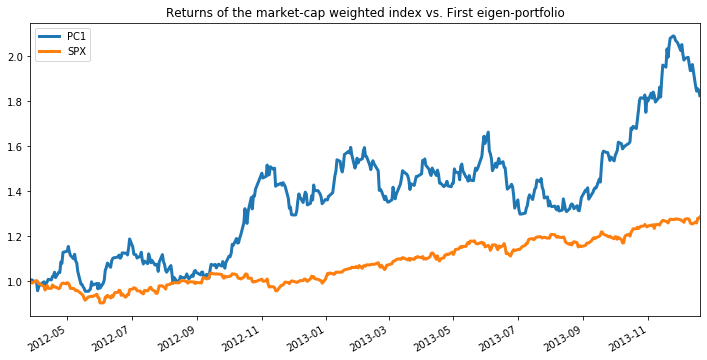

In [62]:
eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, 'SPX': df_raw_test.loc[:, 'SPX']}, index=df_test.index)
np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                         figsize=(12,6), linewidth=3)

In [63]:
eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))

Second eigen-portfolio:
Return = 15.76%
Volatility = 42.84%
Sharpe = 0.37


We repeat the exercise of computing Sharpe ratio for the first N portfolios and select portfolio with the highest postive Sharpe ratio.

/Users/jrosaler/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/jrosaler/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Eigen portfolio #42 with the highest Sharpe. Return 61.14%, vol = 22.80%, Sharpe = 2.68


/Users/jrosaler/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 'Portfolios')

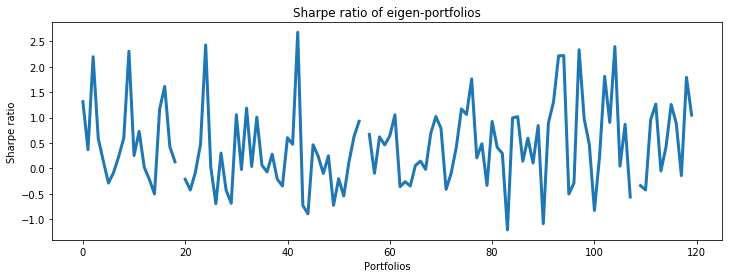

In [64]:
n_portfolios = 120
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0 # index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio
    
for ix in range(n_portfolios):     
    pc_w = pcs[:, ix] / sum(pcs[:, ix])
    eigen_prtf = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf.sort_values(by=['weights'], ascending=False, inplace=True)
    eigen_prtf_returns = np.dot(df_raw_test.loc[:, eigen_prtf.index], eigen_prtf / 100)
    eigen_prtf_returns = pd.Series(eigen_prtf_returns.squeeze(), index=df_test.index)
    ret, vol, sharpe = sharpe_ratio(eigen_prtf_returns)
    annualized_ret[ix] = ret
    annualized_vol[ix] = vol
    sharpe_metric[ix] = sharpe
        
idx_highest_sharpe = np.nanargmax(sharpe_metric)
      
print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
      (idx_highest_sharpe,
       annualized_ret[idx_highest_sharpe]*100, 
       annualized_vol[idx_highest_sharpe]*100, 
       sharpe_metric[idx_highest_sharpe]))

fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
ax.plot(sharpe_metric, linewidth=3)
ax.set_title('Sharpe ratio of eigen-portfolios')
ax.set_ylabel('Sharpe ratio')
ax.set_xlabel('Portfolios')

In [65]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results = results.dropna()
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
results.head(10)

,Return,Vol,Sharpe
42,0.611437,0.228033,2.681354
24,1.032178,0.424530,2.431344
104,0.512464,0.213640,2.398724
97,1.425562,0.609754,2.337929
9,0.753548,0.326692,2.306601
94,0.502025,0.225976,2.221589
93,0.601081,0.271151,2.216774
2,0.453437,0.206247,2.198512
102,0.274142,0.151208,1.813008
118,0.874381,0.487549,1.793422


## Conclusions

The eigenportfolio of stocks in the S&P500 with the 42nd largest variance has the largest annualized Sharpe ratio, of 2.68. By 